In [ ]:
import os
import cv2
import joblib
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn


from PIL import Image
from tqdm import tqdm
from skimage import io
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix


#from tensorflow.keras.preprocessing import image
#from tensorflow.keras.models import model_from_json




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
DATA_DIR = '/content/drive/MyDrive/Data'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'valid')

In [ ]:
IMG_SIZE = 128
CATEGORIES = []
for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
print(CATEGORIES)

['Corn___Healthy', 'Corn___Common_Rust', 'Potato___Healthy', 'Potato___Late_Blight', 'Rice___Brown_Spot', 'Rice___Healthy', 'Invalid___Images']


In [ ]:
classes = len(CATEGORIES)
classes

7

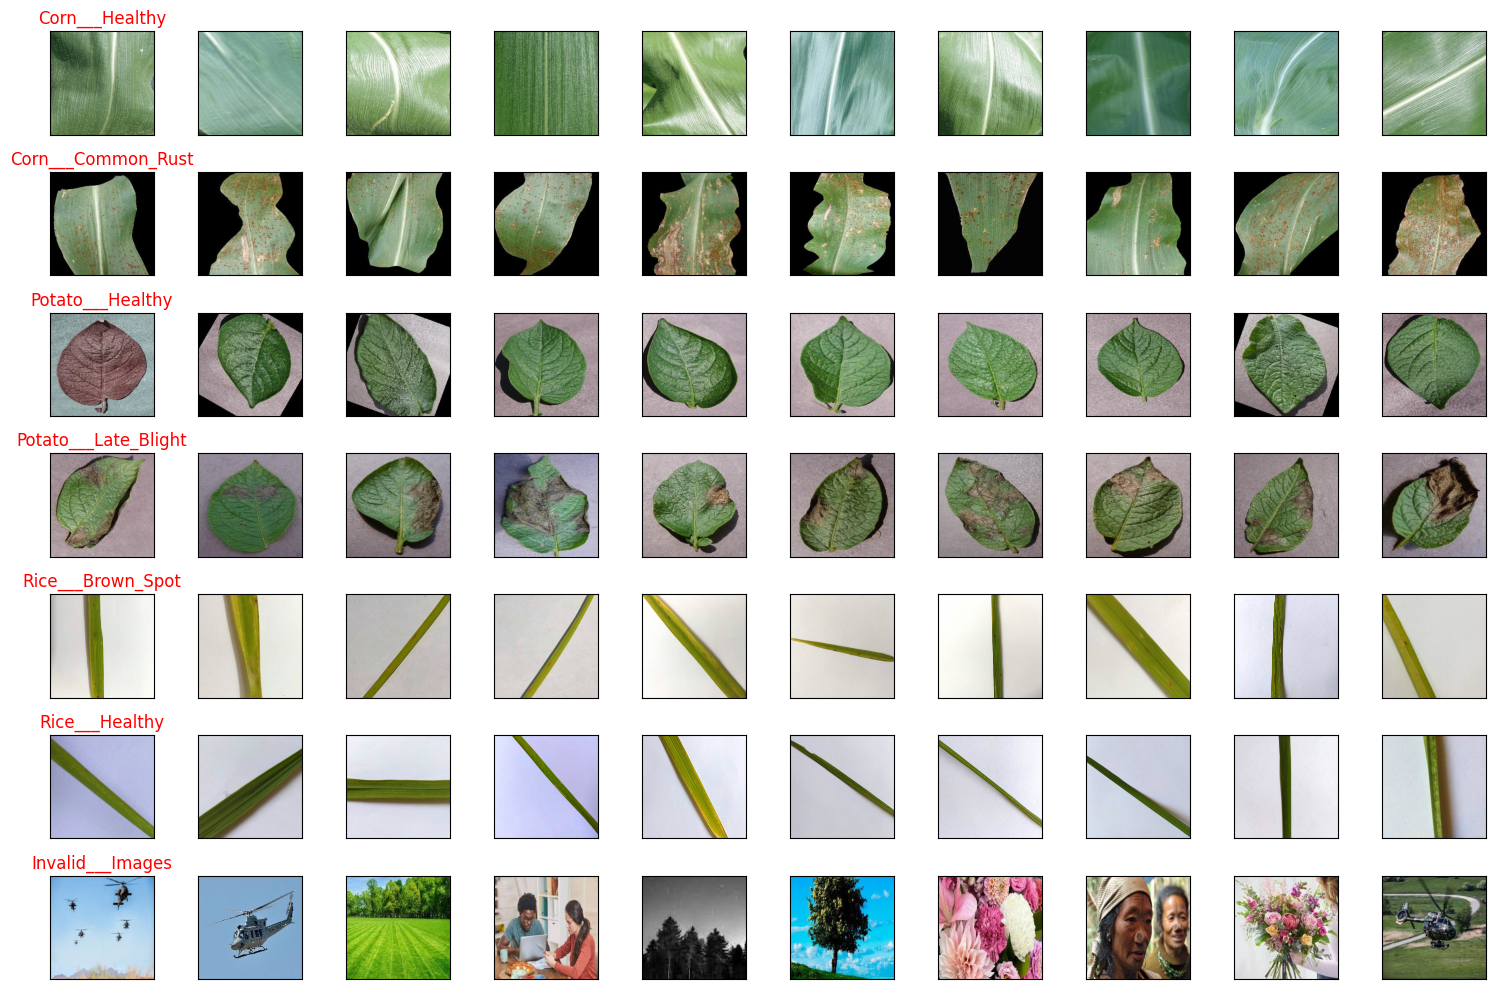

In [ ]:
plt.figure(figsize=(15, 10), facecolor='white')
i = 1
num_images_per_class = 10

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    image_list = os.listdir(path)
    if len(image_list) < num_images_per_class:
        continue
    random.shuffle(image_list)
    image_list = image_list[:num_images_per_class]

    for img_name in image_list:
        img_array = cv2.imread(os.path.join(path, img_name))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        white_background = 255 * np.ones_like(img_array)

        x_offset = (white_background.shape[1] - img_array.shape[1]) // 2
        y_offset = (white_background.shape[0] - img_array.shape[0]) // 2
        white_background[y_offset:y_offset + img_array.shape[0], x_offset:x_offset + img_array.shape[1]] = img_array

        plt.subplot(len(CATEGORIES), num_images_per_class, i)
        plt.imshow(white_background)

        if i % num_images_per_class == 1:
            plt.title(c, color='red')

        plt.xticks([])
        plt.yticks([])
        i += 1

plt.tight_layout()
plt.show()

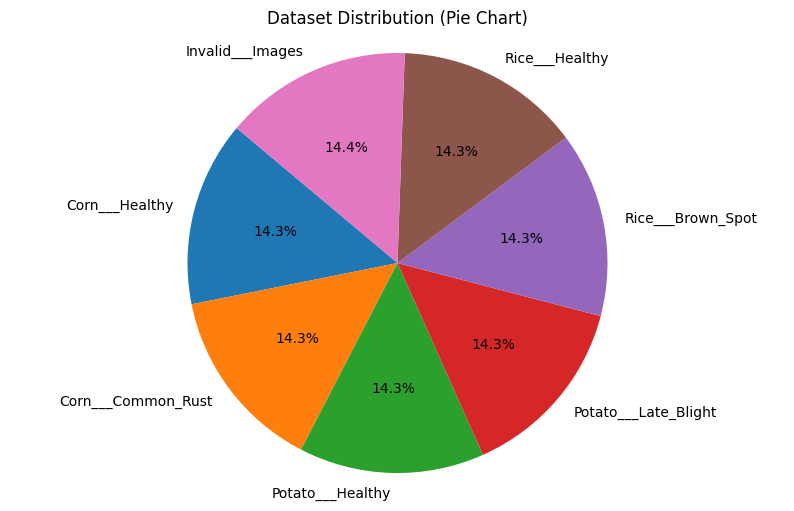

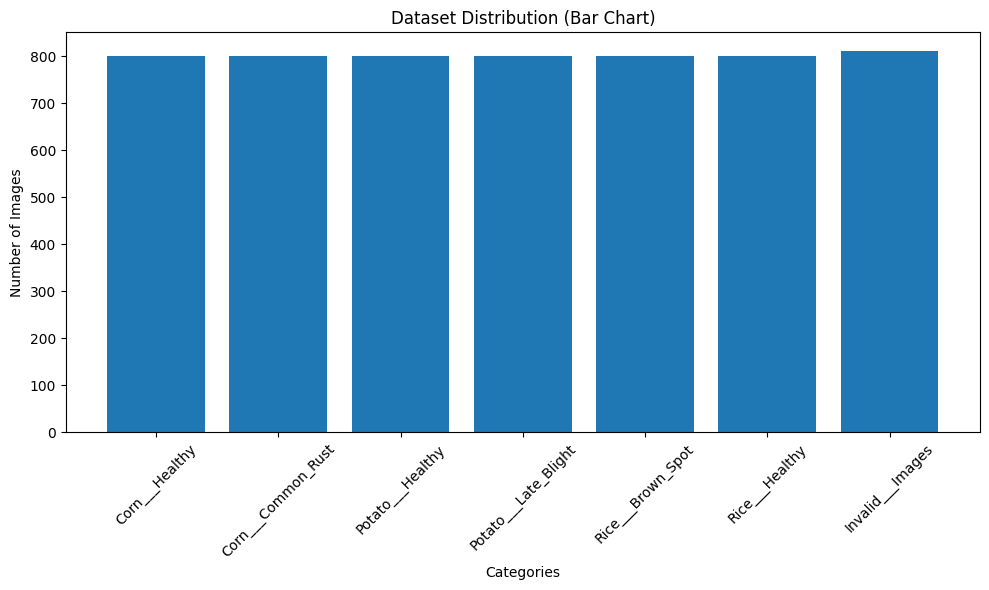

In [ ]:
category_counts = {}
for category in CATEGORIES:
    category_path = os.path.join(TRAIN_DATA_DIR, category)
    num_images = len(os.listdir(category_path))
    category_counts[category] = num_images


plt.figure(figsize=(10, 6), facecolor='white')
plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Dataset Distribution (Pie Chart)')
plt.axis('equal')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values())
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution (Bar Chart)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(training_data))

100%|██████████| 810/810 [00:08<00:00, 97.53it/s] 

5610


In [ ]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(test_data))

100%|██████████| 200/200 [00:01<00:00, 150.23it/s]

1400


In [ ]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)

X_train = np.array(X_train).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (5610, 128, 128, 3) Y_train= (5610,)


In [ ]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")
X_train, X_test = X_train / 255.0, X_test / 255.0

X_test= (1400, 128, 128, 3) Y_test= (1400,)


**ResNet50**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, BatchNormalization, Dropout


resnet = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)
resnet.trainable = False

x = resnet.output
x = GlobalMaxPooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
y = Dense(classes, activation='softmax')(x)

resnet_model = tf.keras.Model(inputs=resnet.input, outputs=y)

resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
resnet50 = resnet_model.fit(
    x=X_train, y=Y_train,
    epochs=10,
    validation_data=(X_test, Y_test),
    batch_size=32
    )

Epoch 1/10
176/176 [==============================] - 12s 63ms/step - loss: 0.9204 - accuracy: 0.6638 - val_loss: 1.3306 - val_accuracy: 0.4721
Epoch 2/10
176/176 [==============================] - 8s 45ms/step - loss: 0.6154 - accuracy: 0.7713 - val_loss: 1.0498 - val_accuracy: 0.5121
Epoch 3/10
176/176 [==============================] - 9s 49ms/step - loss: 0.5170 - accuracy: 0.8005 - val_loss: 0.5250 - val_accuracy: 0.8079
Epoch 4/10
176/176 [==============================] - 9s 50ms/step - loss: 0.4838 - accuracy: 0.8200 - val_loss: 0.5806 - val_accuracy: 0.7593
Epoch 5/10
176/176 [==============================] - 8s 47ms/step - loss: 0.4441 - accuracy: 0.8298 - val_loss: 0.5195 - val_accuracy: 0.7921
Epoch 6/10
176/176 [==============================] - 9s 51ms/step - loss: 0.4277 - accuracy: 0.8364 - val_loss: 0.6956 - val_accuracy: 0.7493
Epoch 7/10
176/176 [==============================] - 9s 50ms/step - loss: 0.4006 - accuracy: 0.8446 - val_loss: 0.5237 - val_accuracy: 0.785

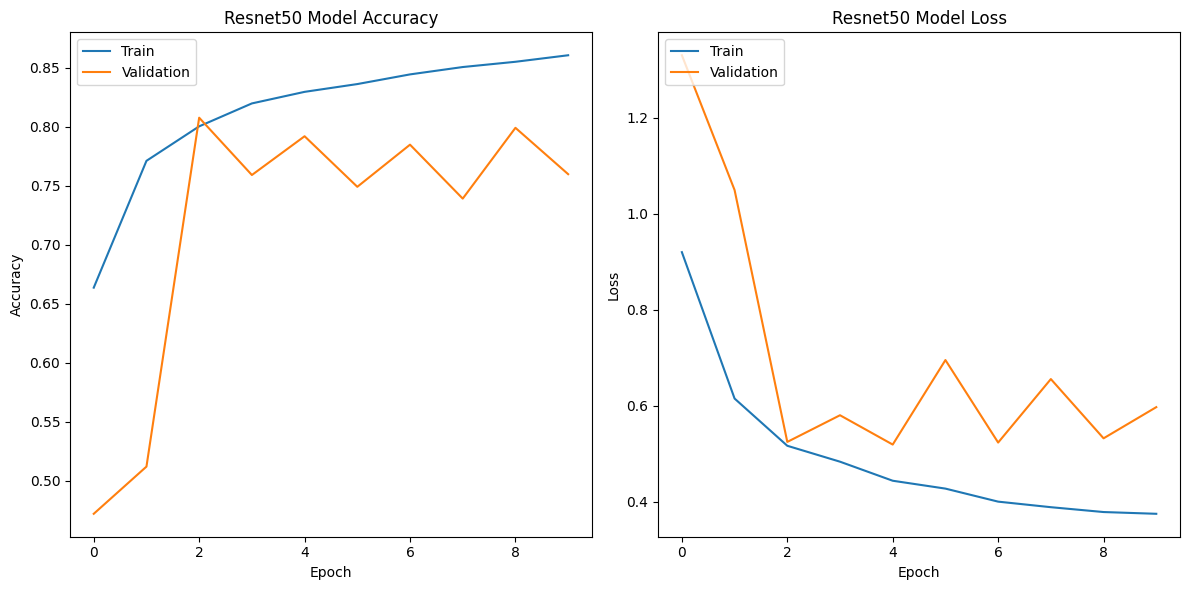

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(resnet50.history['accuracy'])
plt.plot(resnet50.history['val_accuracy'])
plt.title('Resnet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(resnet50.history['loss'])
plt.plot(resnet50.history['val_loss'])
plt.title('Resnet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
train_loss, train_accuracy = resnet_model.evaluate(X_train, Y_train)
print(f'Restne50 Train Accuracy: {train_accuracy * 100:.2f}%')

176/176 [==============================] - 7s 38ms/step - loss: 0.4811 - accuracy: 0.7802
Restne50 Train Accuracy: 78.02%


In [ ]:
test_loss, test_accuracy = resnet_model.evaluate(X_test, Y_test)
print(f'Restne50 Test Accuracy: {test_accuracy * 100:.2f}%')

44/44 [==============================] - 2s 40ms/step - loss: 0.5975 - accuracy: 0.7600
Restne50 Test Accuracy: 76.00%


**Vgg16**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

vgg16 = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

# Freeze the layers in the base model
vgg16.trainable = False

# Create your custom head for the VGG16 model
x = vgg16.output
x = GlobalMaxPooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
y = Dense(classes, activation='softmax')(x)

# Create the VGG16 model
vgg16_model = Model(inputs=vgg16.input, outputs=y)

# Compile the VGG16 model
vgg16_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print a summary of the VGG16 model architecture


In [ ]:
vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
Vgg16 = vgg16_model.fit(
    x=X_train, y=Y_train,
    epochs=10,
    validation_data=(X_test, Y_test),
    batch_size=32
    )

Epoch 1/10
176/176 [==============================] - 12s 71ms/step - loss: 0.3449 - accuracy: 0.8586 - val_loss: 0.2640 - val_accuracy: 0.8879
Epoch 2/10
176/176 [==============================] - 11s 60ms/step - loss: 0.3207 - accuracy: 0.8693 - val_loss: 0.2506 - val_accuracy: 0.8957
Epoch 3/10
176/176 [==============================] - 11s 61ms/step - loss: 0.3064 - accuracy: 0.8717 - val_loss: 0.2348 - val_accuracy: 0.8986
Epoch 4/10
176/176 [==============================] - 13s 73ms/step - loss: 0.2893 - accuracy: 0.8840 - val_loss: 0.2257 - val_accuracy: 0.9079
Epoch 5/10
176/176 [==============================] - 13s 72ms/step - loss: 0.2720 - accuracy: 0.8873 - val_loss: 0.2173 - val_accuracy: 0.9093
Epoch 6/10
176/176 [==============================] - 13s 72ms/step - loss: 0.2610 - accuracy: 0.8971 - val_loss: 0.2110 - val_accuracy: 0.9114
Epoch 7/10
176/176 [==============================] - 10s 59ms/step - loss: 0.2497 - accuracy: 0.8986 - val_loss: 0.2027 - val_accuracy:

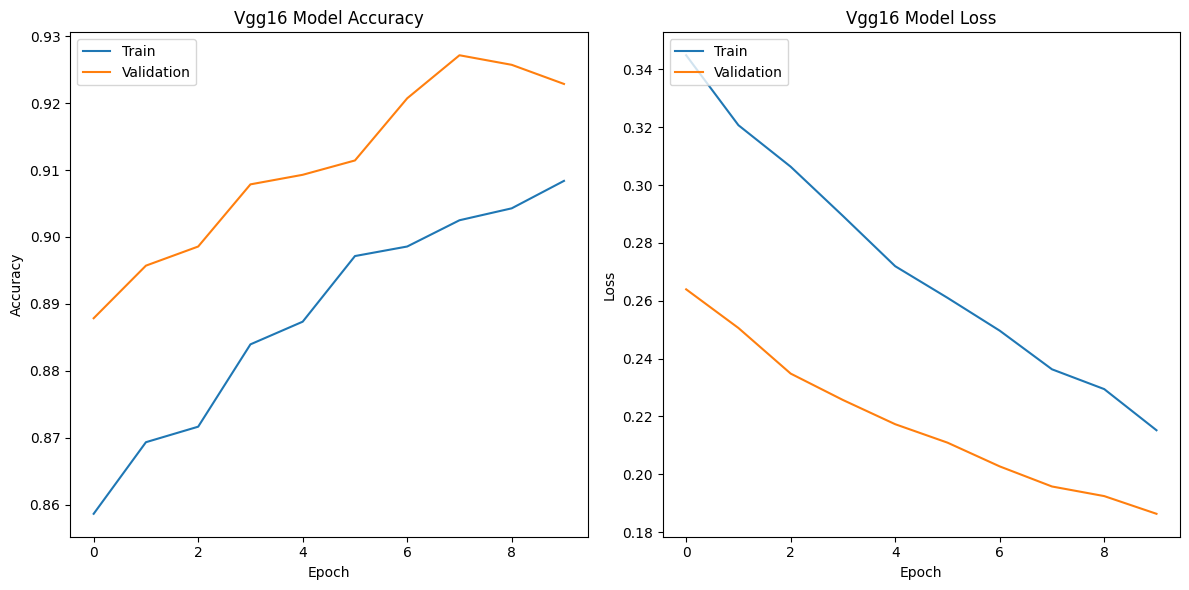

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(Vgg16.history['accuracy'])
plt.plot(Vgg16.history['val_accuracy'])
plt.title('Vgg16 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(Vgg16.history['loss'])
plt.plot(Vgg16.history['val_loss'])
plt.title('Vgg16 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
train_loss, train_accuracy = vgg16_model.evaluate(X_train, Y_train)
print(f'Vgg16 Train Accuracy: {train_accuracy * 100:.2f}%')

176/176 [==============================] - 8s 42ms/step - loss: 0.1552 - accuracy: 0.9399
Vgg16 Train Accuracy: 93.99%


In [ ]:
test_loss, test_accuracy = vgg16_model.evaluate(X_test, Y_test)
print(f'Vgg16 Test Accuracy: {test_accuracy * 100:.2f}%')

44/44 [==============================] - 2s 42ms/step - loss: 0.1864 - accuracy: 0.9229
Vgg16 Test Accuracy: 92.29%


**CNN**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
basic_cnn = models.Sequential()

# Convolutional layers
basic_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
basic_cnn.add(layers.MaxPooling2D((2, 2)))
basic_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
basic_cnn.add(layers.MaxPooling2D((2, 2)))
basic_cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
basic_cnn.add(layers.MaxPooling2D((2, 2)))

# Flatten the output before the fully connected layers
basic_cnn.add(layers.Flatten())

# Fully connected layers
basic_cnn.add(layers.Dense(256, activation='relu'))
basic_cnn.add(layers.Dropout(0.5))  # Optional dropout layer for regularization
basic_cnn.add(layers.Dense(128, activation='relu'))
basic_cnn.add(layers.Dense(classes, activation='softmax'))  # Output layer, adjust 'classes' based on your task

# Compile the model
basic_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
basic_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [ ]:
CNN= basic_cnn.fit(
    x=X_train, y=Y_train,
    epochs=5,
    validation_data=(X_test, Y_test),
    batch_size=32
    )

Epoch 1/5
176/176 [==============================] - 4s 25ms/step - loss: 0.0883 - accuracy: 0.9706 - val_loss: 0.1403 - val_accuracy: 0.9621
Epoch 2/5
176/176 [==============================] - 4s 20ms/step - loss: 0.0998 - accuracy: 0.9658 - val_loss: 0.1251 - val_accuracy: 0.9586
Epoch 3/5
176/176 [==============================] - 3s 20ms/step - loss: 0.0584 - accuracy: 0.9775 - val_loss: 0.1704 - val_accuracy: 0.9471
Epoch 4/5
176/176 [==============================] - 4s 21ms/step - loss: 0.0662 - accuracy: 0.9797 - val_loss: 0.2016 - val_accuracy: 0.9493
Epoch 5/5
176/176 [==============================] - 5s 26ms/step - loss: 0.1662 - accuracy: 0.9399 - val_loss: 0.1801 - val_accuracy: 0.9371


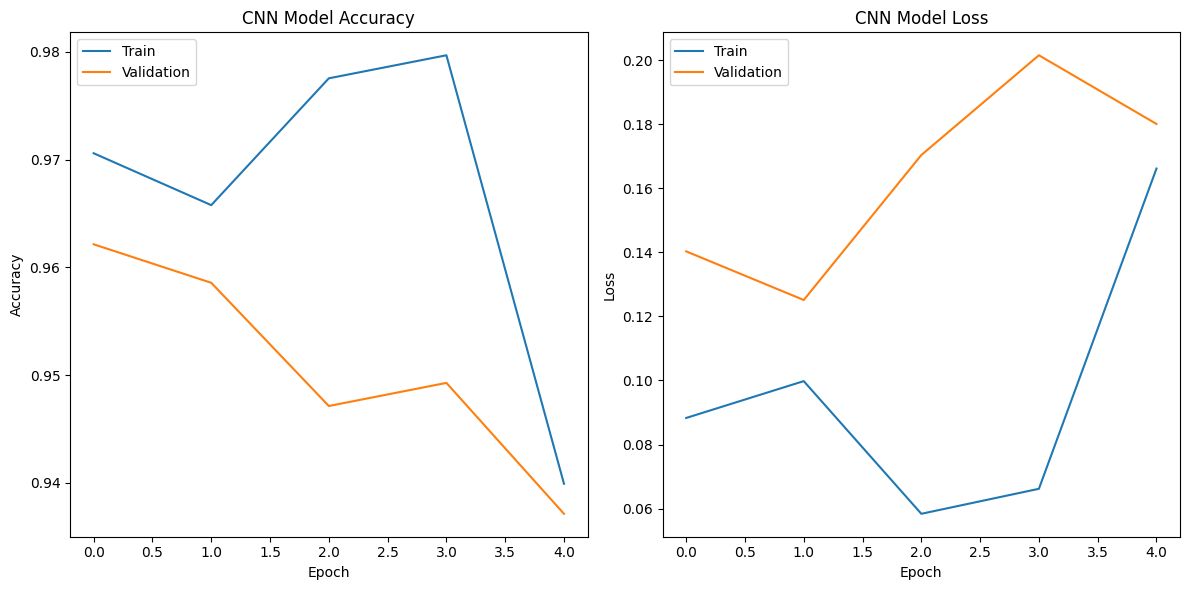

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(CNN.history['accuracy'])
plt.plot(CNN.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(CNN.history['loss'])
plt.plot(CNN.history['val_loss'])
plt.title('CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
train_loss, train_accuracy = basic_cnn.evaluate(X_train, Y_train)
print(f'CNN Train Accuracy: {train_accuracy * 100:.2f}%')

176/176 [==============================] - 1s 8ms/step - loss: 0.0843 - accuracy: 0.9649
CNN Train Accuracy: 96.49%


In [ ]:
test_loss, test_accuracy = basic_cnn.evaluate(X_test, Y_test)
print(f'CNN Test Accuracy: {test_accuracy * 100:.2f}%')

44/44 [==============================] - 0s 9ms/step - loss: 0.1801 - accuracy: 0.9371
CNN Test Accuracy: 93.71%


Efficientnet


In [ ]:
#pip install -q efficientnet

### Enet B0

In [ ]:
enet = efn.EfficientNetB0(
    input_shape=(128, 128, 3),
    weights='imagenet',
    include_top=False
)

enet.trainable = False
x = enet.output
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
y = tf.keras.layers.Dense(classes, activation='softmax')(x)


e_model_b0= tf.keras.Model(inputs=enet.input, outputs=y)

e_model_b0.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
e_model_b0.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 64, 64, 32)           864       ['input_3[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 64, 64, 32)           128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 64, 64, 32)           0         ['stem_bn[0][0]']       

In [ ]:
efficientnet_b0 = e_model_b0.fit(
    x=X_train, y=Y_train,
    epochs=10,
    validation_data=(X_test, Y_test),
    batch_size=32
    )

Epoch 1/10
176/176 [==============================] - 14s 43ms/step - loss: 0.4972 - accuracy: 0.8201 - val_loss: 0.1957 - val_accuracy: 0.9271
Epoch 2/10
176/176 [==============================] - 6s 34ms/step - loss: 0.2235 - accuracy: 0.9127 - val_loss: 0.1663 - val_accuracy: 0.9350
Epoch 3/10
176/176 [==============================] - 5s 29ms/step - loss: 0.1961 - accuracy: 0.9269 - val_loss: 0.1459 - val_accuracy: 0.9436
Epoch 4/10
176/176 [==============================] - 6s 32ms/step - loss: 0.1603 - accuracy: 0.9321 - val_loss: 0.1679 - val_accuracy: 0.9386
Epoch 5/10
176/176 [==============================] - 5s 31ms/step - loss: 0.1451 - accuracy: 0.9435 - val_loss: 0.1680 - val_accuracy: 0.9421
Epoch 6/10
176/176 [==============================] - 5s 30ms/step - loss: 0.1329 - accuracy: 0.9478 - val_loss: 0.1283 - val_accuracy: 0.9521
Epoch 7/10
176/176 [==============================] - 5s 29ms/step - loss: 0.1290 - accuracy: 0.9496 - val_loss: 0.1304 - val_accuracy: 0.952

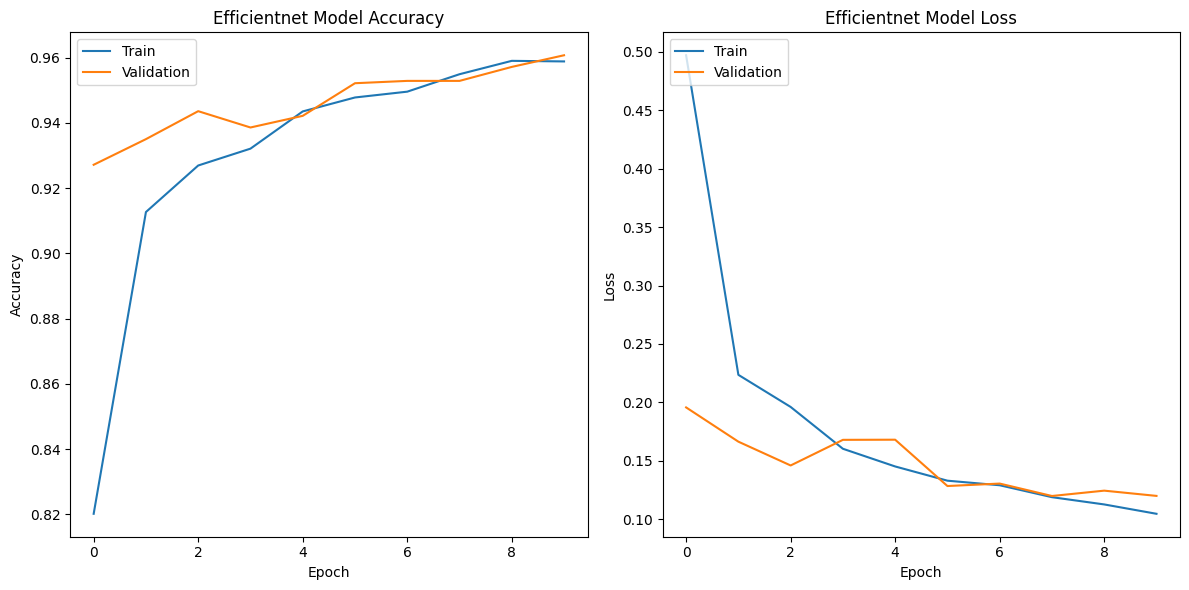

In [ ]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(efficientnet_b0.history['accuracy'])
plt.plot(efficientnet_b0.history['val_accuracy'])
plt.title('Efficientnet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(efficientnet_b0.history['loss'])
plt.plot(efficientnet_b0.history['val_loss'])
plt.title('Efficientnet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_accuracy = e_model_b0.evaluate(X_train, Y_train)
print(f'Efficientnet Train Accuracy: {test_accuracy * 100:.2f}%')

176/176 [==============================] - 5s 25ms/step - loss: 0.0629 - accuracy: 0.9790
Efficientnet Train Accuracy: 97.90%


In [ ]:
test_loss, test_accuracy = e_model_b0.evaluate(X_test, Y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

44/44 [==============================] - 1s 25ms/step - loss: 0.1199 - accuracy: 0.9607
Efficientnet Test Accuracy: 96.07%
